<a href="https://colab.research.google.com/github/bhopchi/Deep-Learning-Based-White-Blood-Cell-Classification-using-Multi-Head-Attention-Mechanism/blob/main/Deep_Learning_Based_White_Blood_Cell_Classification_using_Multi_Head_Attention_Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import zipfile

# Replace 'your_dataset.zip' with the actual path to your zipped dataset file
zip_file_path = '/content/original_images.zip'
extract_path = '/content/original_images'  # Specify the extraction path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: /content/original_images


In [30]:
import os
import pandas as pd

base_path = "/content/original_images/original_images"
cell_types = ["basophil", "eosinophil", "erythroblast", "lymphocyte", "ig", "monocyte", "neutrophil", "platelet"]

data = []

for cell_type in cell_types:
    folder_path = os.path.join(base_path, cell_type)
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                data.append({"Image_Path": file_path, "Label": cell_type})

df = pd.DataFrame(data)
print(df.head())


                                          Image_Path     Label
0  /content/original_images/original_images/basop...  basophil
1  /content/original_images/original_images/basop...  basophil
2  /content/original_images/original_images/basop...  basophil
3  /content/original_images/original_images/basop...  basophil
4  /content/original_images/original_images/basop...  basophil


In [31]:
df.tail()

Image_Path     Label
1555  /content/original_images/original_images/plate...  platelet
1556  /content/original_images/original_images/plate...  platelet
1557  /content/original_images/original_images/plate...  platelet
1558  /content/original_images/original_images/plate...  platelet
1559  /content/original_images/original_images/plate...  platelet

In [32]:
df.shape

(1560, 2)

In [33]:
df.columns

Index(['Image_Path', 'Label'], dtype='object')

In [34]:
df.duplicated().sum()

0

In [35]:
df.isnull().sum()

Image_Path    0
Label         0
dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  1560 non-null   object
 1   Label       1560 non-null   object
dtypes: object(2)
memory usage: 24.5+ KB


In [37]:
df.nunique()

Image_Path    1560
Label            8
dtype: int64

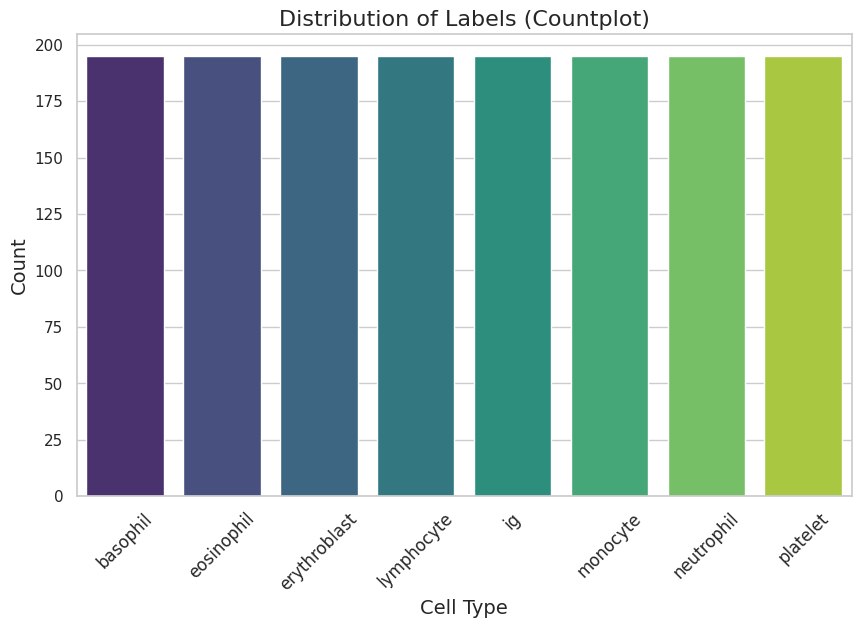

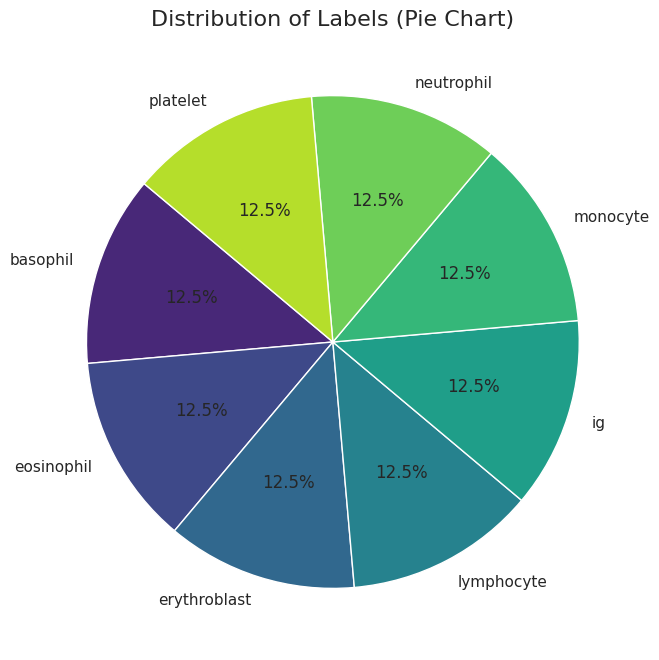

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the theme for Seaborn plots
sns.set_theme(style="whitegrid")

# Countplot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x="Label",
    order=df['Label'].value_counts().index,
    palette="viridis"
)
plt.title("Distribution of Labels (Countplot)", fontsize=16)
plt.xlabel("Cell Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

# Pie chart
plt.figure(figsize=(8, 8))
df['Label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("viridis", len(df['Label'].unique()))
)
plt.title("Distribution of Labels (Pie Chart)", fontsize=16)
plt.ylabel("")  # Removes the default y-axis label
plt.show()


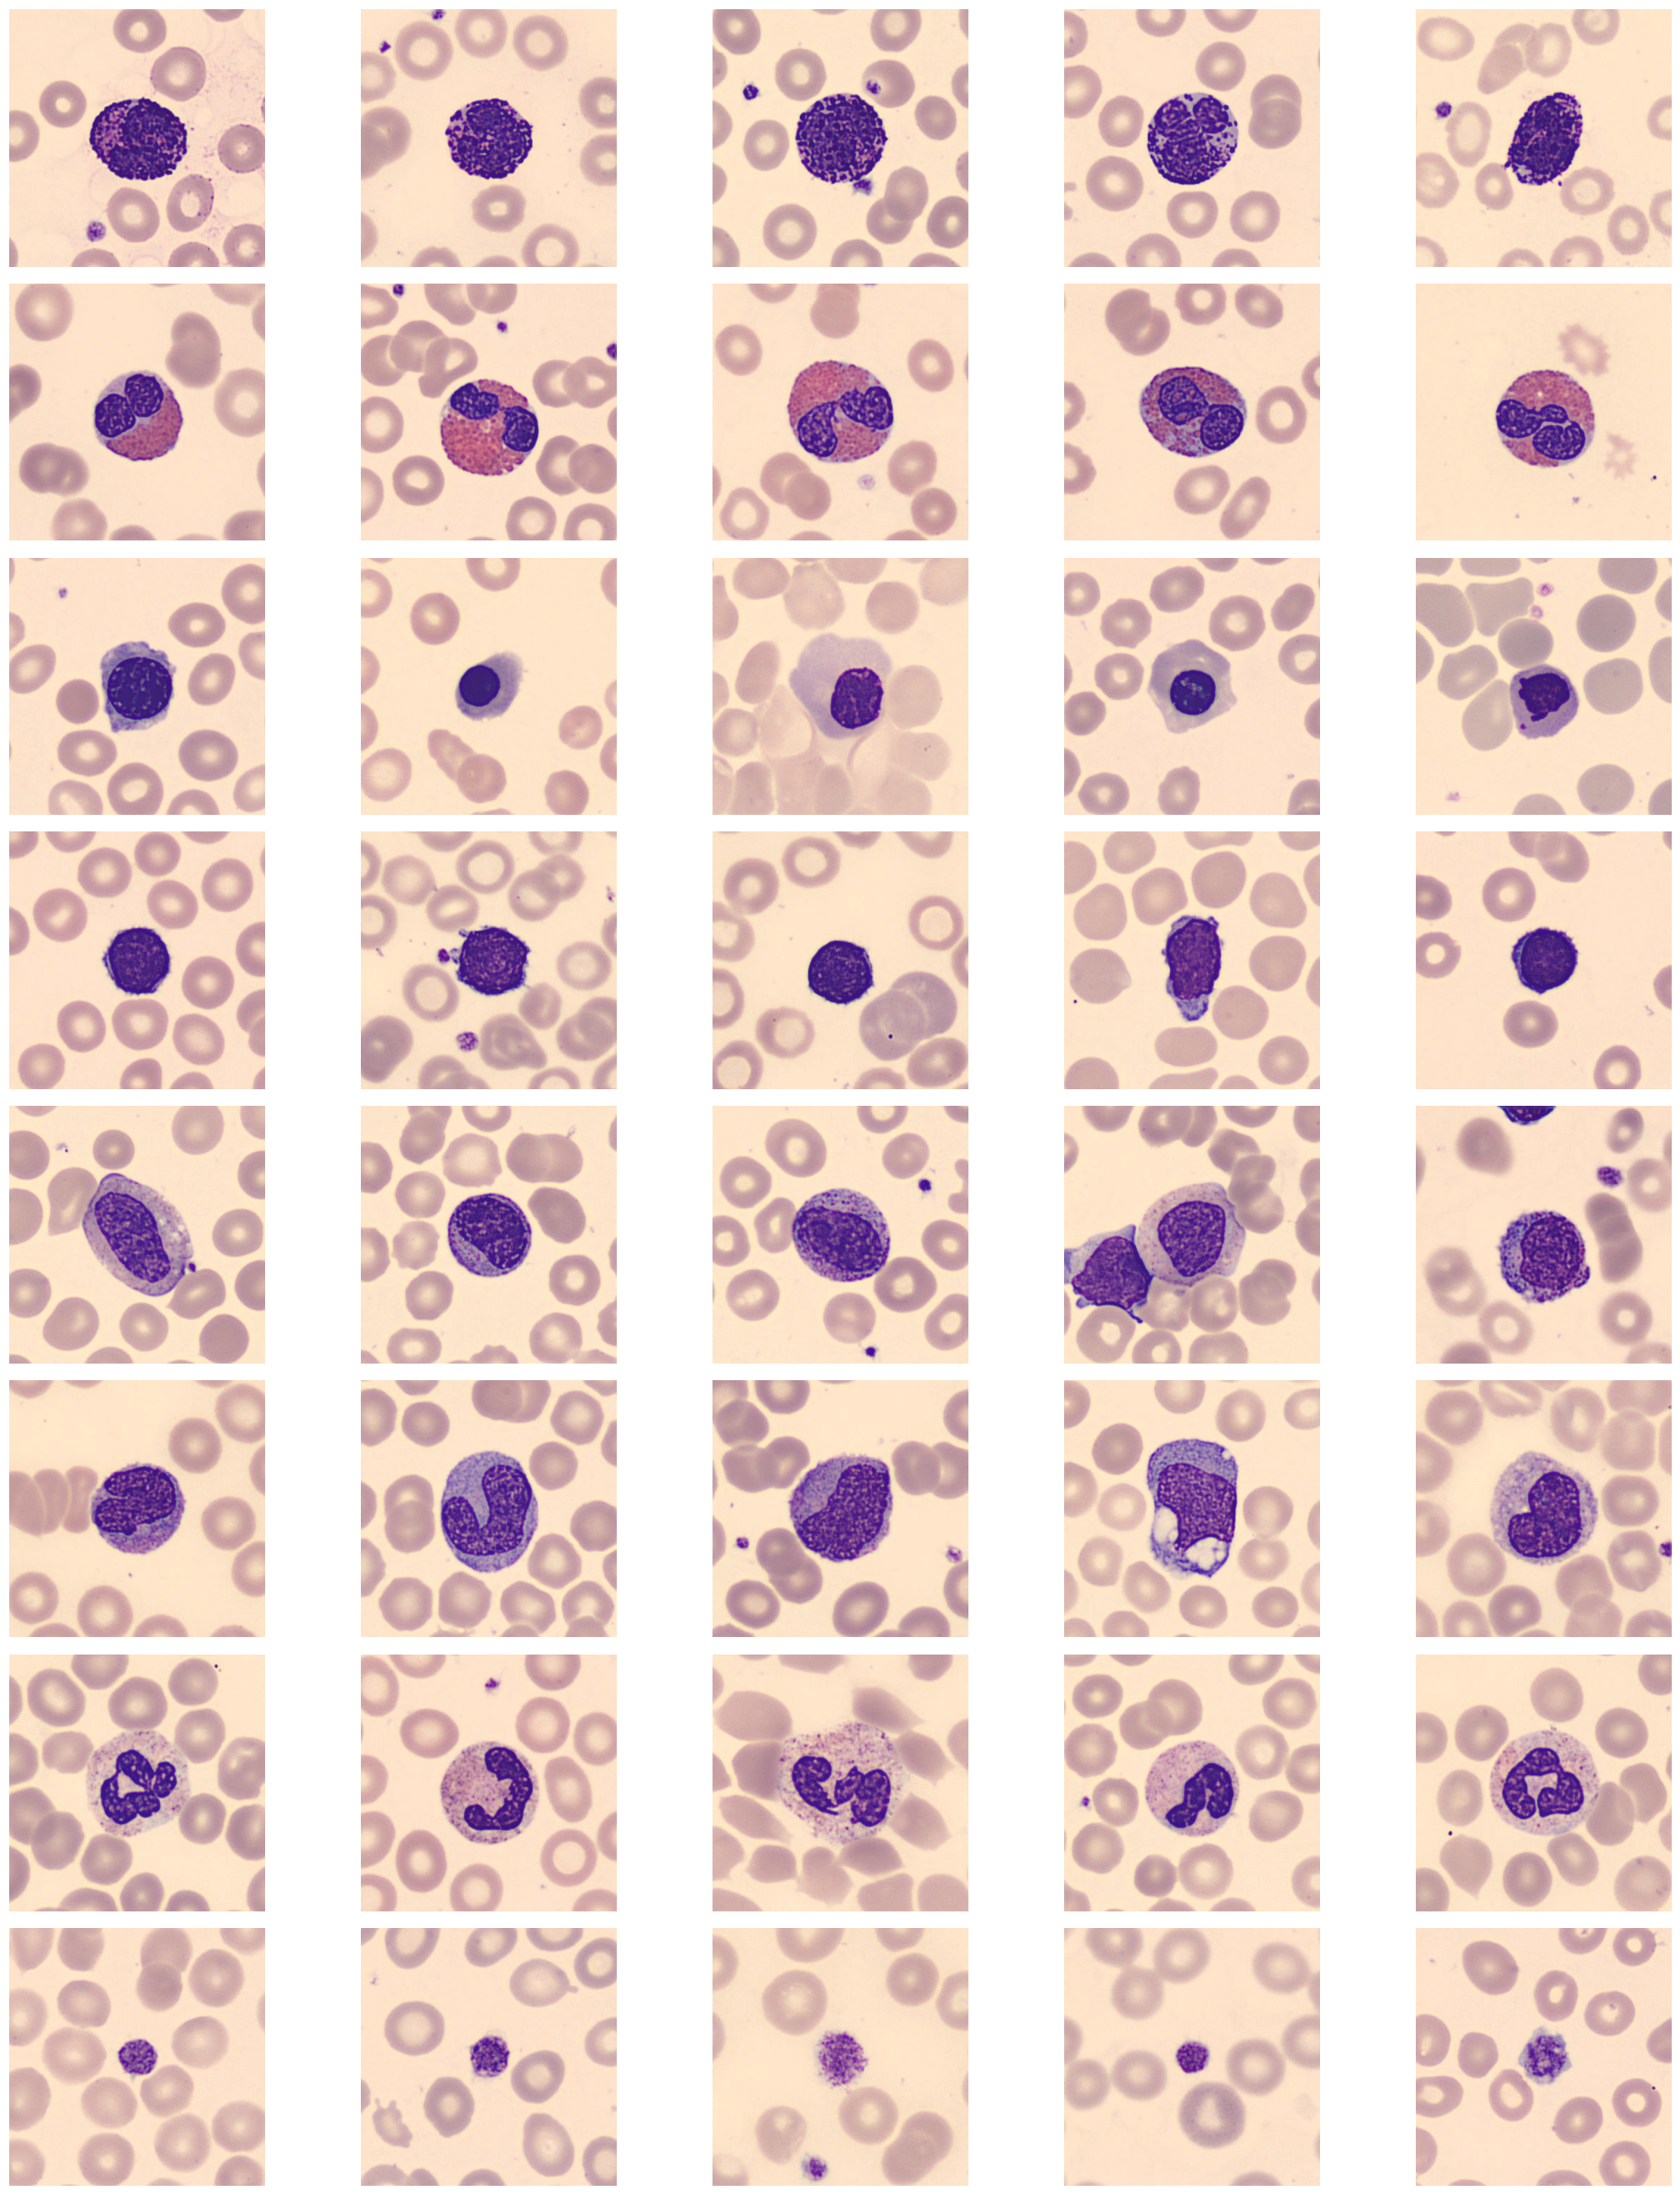

In [39]:
import cv2
import matplotlib.pyplot as plt

samples_per_category = 5
plt.figure(figsize=(20, len(df['Label'].unique()) * 3))

for idx, label in enumerate(df['Label'].unique()):
    # Get a sample of images for the current label
    sample_images = df[df['Label'] == label].sample(n=samples_per_category, random_state=42)

    for i, img_path in enumerate(sample_images['Image_Path']):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Create a subplot for each image
        plt.subplot(len(df['Label'].unique()), samples_per_category, idx * samples_per_category + i + 1)
        plt.imshow(img)
        plt.axis('off')

        # Add the label as a y-axis title for the first image in each row
        if i == 0:
            plt.ylabel(label, fontsize=14)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


In [40]:
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
)
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings("ignore")

print('Check')


Check


In [41]:
# Ensure the DataFrame 'df' exists before proceeding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Check if 'Label' column exists in the DataFrame
if 'Label' in df.columns:
    df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label Encoding Mapping:")
    print(label_mapping)
else:
    raise ValueError("The DataFrame does not contain a 'Label' column.")

# Ensure 'Label' column is a string type
df['Label'] = df['Label'].astype(str)

# Split the DataFrame
train_df_new, temp_df_new = train_test_split(
    df, train_size=0.8, shuffle=True, random_state=42
)
# Split the dataset
temp_df_new, valid_df_new = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=42, stratify=df['Label']
)
valid_df_new, test_df_new = train_test_split(
    temp_df_new, test_size=0.5, shuffle=True, random_state=42, stratify=temp_df_new['Label']
)


Label Encoding Mapping:
{'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6, 'platelet': 7}


In [42]:
# Import required module
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
batch_size = 16
img_size = (299, 299)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create ImageDataGenerators
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

# Flow from dataframe for training, validation, and test sets
train_gen_new = tr_gen.flow_from_dataframe(
    df,
    x_col='Image_Path',
    y_col='Label',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='Image_Path',
    y_col='Label',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='Image_Path',
    y_col='Label',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)


Found 1560 validated image filenames belonging to 8 classes.
Found 624 validated image filenames belonging to 8 classes.
Found 624 validated image filenames belonging to 8 classes.


In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")


Using GPU


In [44]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,
    GaussianNoise, Input, MultiHeadAttention, Reshape
)
from tensorflow.keras.optimizers import Adam

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Function to create the Xception-based model
def create_xception_model(input_shape, num_classes=8, learning_rate=0.0001):
    inputs = Input(shape=input_shape, name="Input_Layer")

    # Load pre-trained Xception model
    base_model = Xception(weights='imagenet', input_tensor=inputs, include_top=False)
    base_model.trainable = False

    # Extract features
    x = base_model.output
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]

    # Attention mechanism
    x = Reshape((height * width, channels), name="Reshape_to_Sequence")(x)
    attention_output = MultiHeadAttention(
        num_heads=8, key_dim=channels, name="Multi_Head_Attention"
    )(x, x)
    attention_output = Reshape((height, width, channels), name="Reshape_to_Spatial")(attention_output)

    # Additional layers
    x = GaussianNoise(0.25, name="Gaussian_Noise_1")(attention_output)
    x = GlobalAveragePooling2D(name="Global_Avg_Pooling")(x)
    x = Dense(512, activation='relu', name="FC_512")(x)
    x = BatchNormalization(name="Batch_Normalization")(x)
    x = GaussianNoise(0.25, name="Gaussian_Noise_2")(x)
    x = Dropout(0.25, name="Dropout")(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax', name="Output_Layer")(x)

    # Compile the model
    model = Model(inputs=inputs, outputs=outputs, name="Xception_with_Attention")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define input shape and create the model
input_shape = (299, 299, 3)
cnn_model = create_xception_model(input_shape, num_classes=8, learning_rate=0.0001)

# Train the model
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=8,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 63s 547ms/step - accuracy: 0.5629 - loss: 1.3090 - val_accuracy: 0.6282 - val_loss: 1.0297
Epoch 2/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 48s 490ms/step - accuracy: 0.8687 - loss: 0.4011 - val_accuracy: 0.8766 - val_loss: 0.3337
Epoch 3/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 468ms/step - accuracy: 0.9005 - loss: 0.3038 - val_accuracy: 0.9151 - val_loss: 0.2452
Epoch 4/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 481ms/step - accuracy: 0.9330 - loss: 0.2124 - val_accuracy: 0.7612 - val_loss: 1.0064
Epoch 5/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 460ms/step - accuracy: 0.9348 - loss: 0.2026 - val_accuracy: 0.8750 - val_loss: 0.3082
Epoch 6/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 470ms/step - accuracy: 0.9526 - loss: 0.1534 - val_accuracy: 0.9199 - val_loss: 0.2168
Epoch 7/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 488ms/step - accuracy: 0.9544 - loss: 0.1351 - val_accuracy: 0.9439 - val_loss: 0.1567
Epoch 8/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 79s 462ms/step - accuracy: 0.9728 - loss: 0.0801 - val_accuracy: 0.

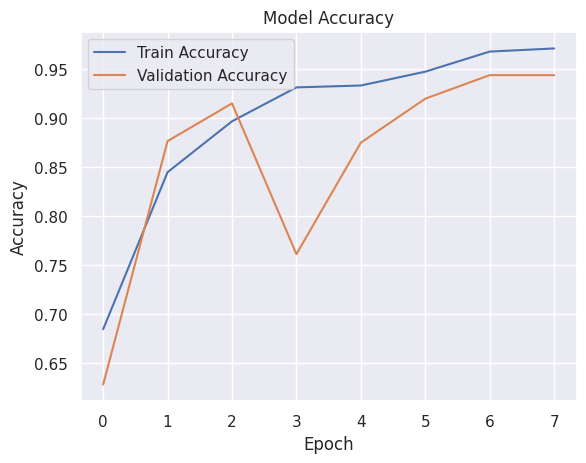

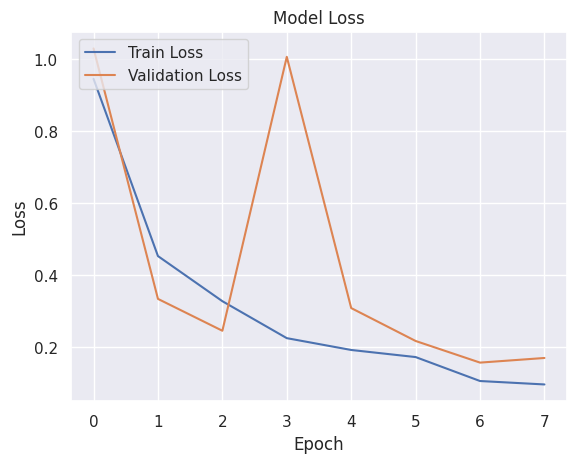

In [45]:
# Plot model accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot model loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [46]:
import numpy as np
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)


39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step


In [47]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

    basophil       0.97      0.97      0.97        78
  eosinophil       1.00      0.82      0.90        78
erythroblast       1.00      0.90      0.95        78
          ig       1.00      0.88      0.94        78
  lymphocyte       1.00      1.00      1.00        78
    monocyte       1.00      0.97      0.99        78
  neutrophil       0.70      1.00      0.83        78
    platelet       1.00      1.00      1.00        78

    accuracy                           0.94       624
   macro avg       0.96      0.94      0.95       624
weighted avg       0.96      0.94      0.95       624



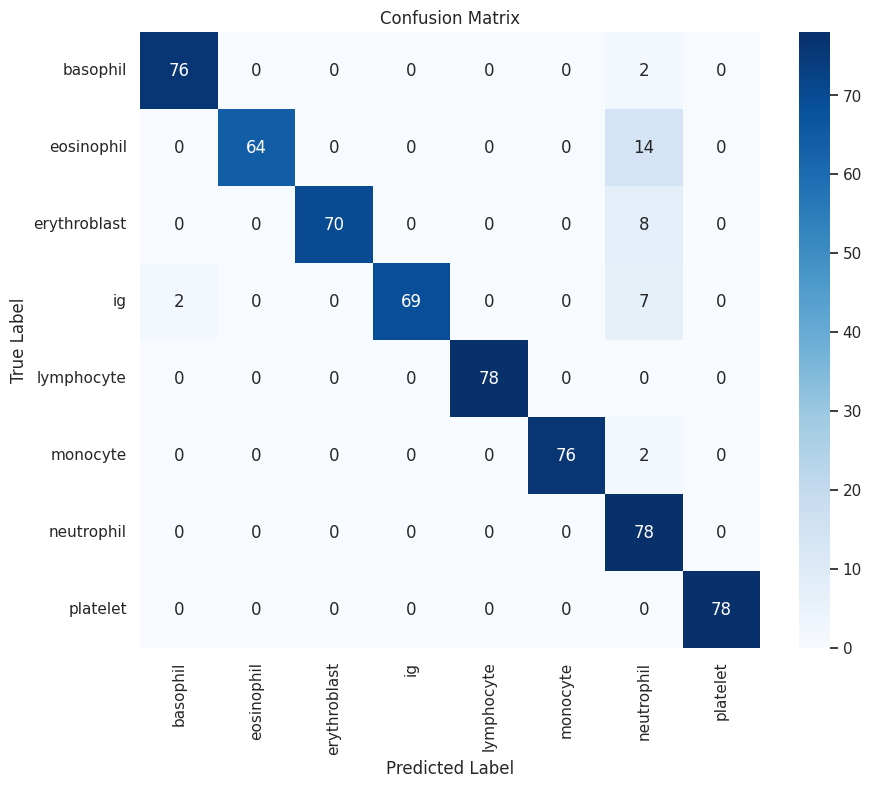

In [48]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_gen_new.class_indices.keys()),
            yticklabels=list(test_gen_new.class_indices.keys()))

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [49]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,
                                     GaussianNoise, Input, MultiHeadAttention, Reshape)
from tensorflow.keras.optimizers import Adam

def create_mobilenet_model(input_shape, num_classes=8, learning_rate=0.0001):
    inputs = Input(shape=input_shape, name="Input_Layer")
    base_model = MobileNet(weights='imagenet', input_tensor=inputs, include_top=False)
    base_model.trainable = False

    x = base_model.output
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]

    x = Reshape((height * width, channels), name="Reshape_to_Sequence")(x)

    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels, name="Multi_Head_Attention")(x, x)
    attention_output = Reshape((height, width, channels), name="Reshape_to_Spatial")(attention_output)

    x = GaussianNoise(0.25, name="Gaussian_Noise_1")(attention_output)
    x = GlobalAveragePooling2D(name="Global_Avg_Pooling")(x)
    x = Dense(512, activation='relu', name="FC_512")(x)
    x = BatchNormalization(name="Batch_Normalization")(x)
    x = GaussianNoise(0.25, name="Gaussian_Noise_2")(x)
    x = Dropout(0.25, name="Dropout")(x)

    outputs = Dense(num_classes, activation='softmax', name="Output_Layer")(x)

    model = Model(inputs=inputs, outputs=outputs, name="MobileNet_with_Attention")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = (299, 299, 3)
cnn_model = create_mobilenet_model(input_shape, num_classes=8, learning_rate=0.0001)


In [50]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=8,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - accuracy: 0.6482 - loss: 1.0399 - val_accuracy: 0.9327 - val_loss: 0.3439
Epoch 2/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9199 - loss: 0.2467 - val_accuracy: 0.7067 - val_loss: 0.9394
Epoch 3/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9555 - loss: 0.1571 - val_accuracy: 0.9856 - val_loss: 0.0424
Epoch 4/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.9687 - loss: 0.0957 - val_accuracy: 0.9151 - val_loss: 0.3173
Epoch 5/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.9846 - loss: 0.0641 - val_accuracy: 0.9824 - val_loss: 0.0512
Epoch 6/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9929 - loss: 0.0417 - val_accuracy: 0.9872 - val_loss: 0.0344
Epoch 7/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9929 - loss: 0.0419 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 8/8
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9982 - loss: 0.0190 - val_accuracy: 0.

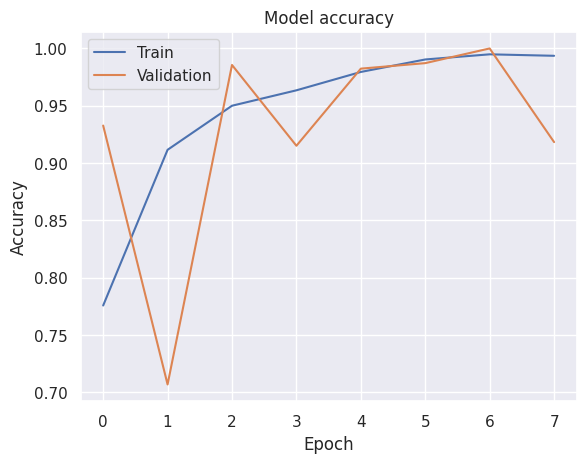

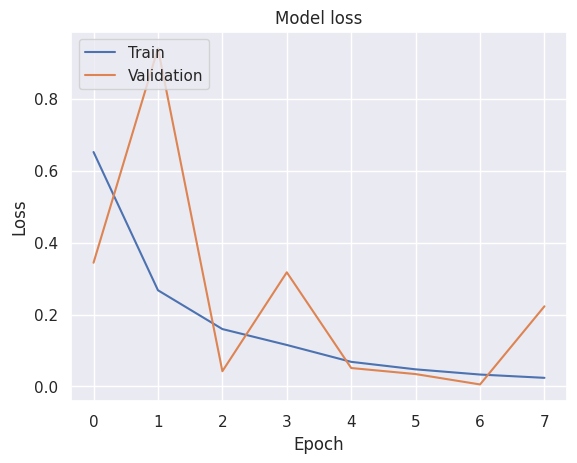

In [51]:
# Plot model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [52]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

# Print the classification report
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
              precision    recall  f1-score   support

    basophil       1.00      1.00      1.00        78
  eosinophil       1.00      1.00      1.00        78
erythroblast       1.00      1.00      1.00        78
          ig       1.00      1.00      1.00        78
  lymphocyte       1.00      1.00      1.00        78
    monocyte       1.00      1.00      1.00        78
  neutrophil       1.00      1.00      1.00        78
    platelet       1.00      1.00      1.00        78

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624



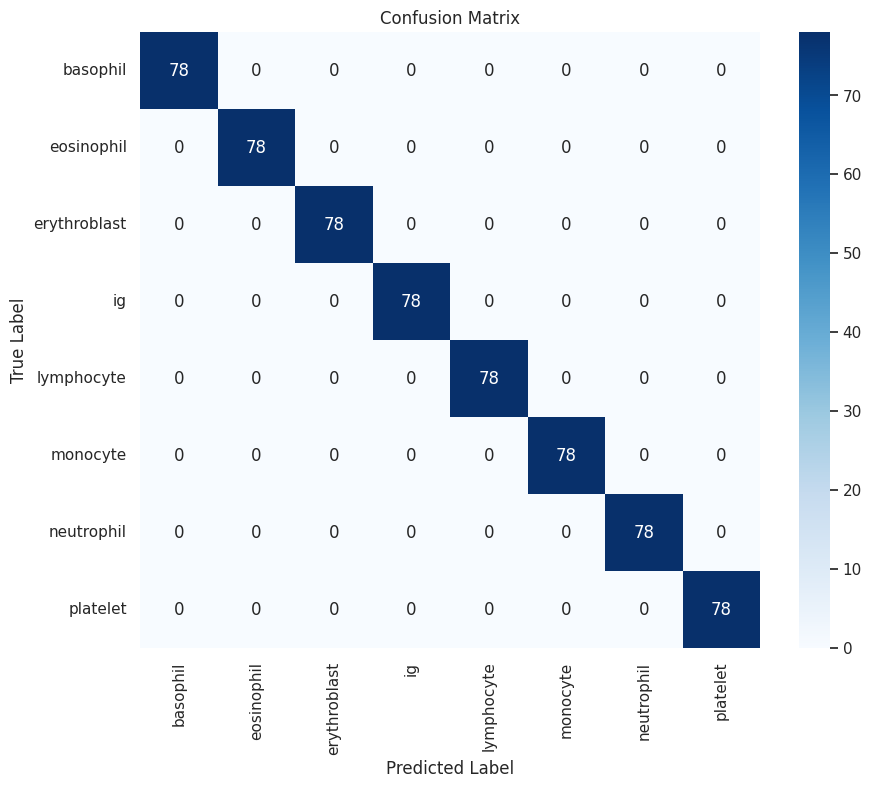

In [53]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_gen_new.class_indices.keys()),
            yticklabels=list(test_gen_new.class_indices.keys()))

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


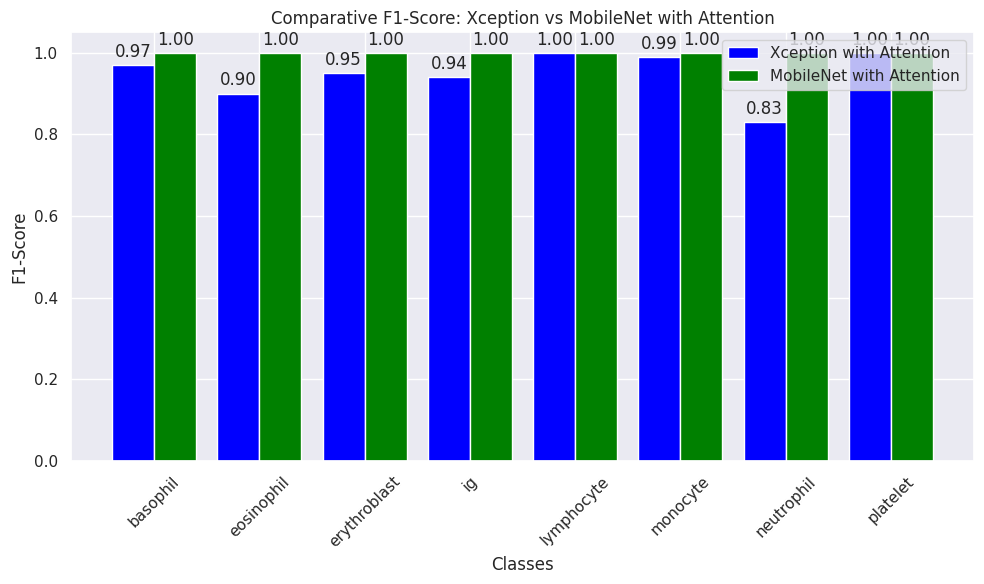

In [55]:
labels = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
xception_f1_scores =  [0.97, 0.90, 0.95, 0.94, 1.00, 0.99, 0.83, 1.00]
mobilenet_f1_scores = [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]

x = np.arange(len(labels))

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, xception_f1_scores, 0.4, label='Xception with Attention', color='blue')
plt.bar(x + 0.2, mobilenet_f1_scores, 0.4, label='MobileNet with Attention', color='green')

# Labels and title
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('Comparative F1-Score: Xception vs MobileNet with Attention')

# X-ticks
plt.xticks(x, labels, rotation=45)

# Add legend
plt.legend()

# Add text labels on top of the bars
for i in range(len(x)):
    plt.text(x[i] - 0.2, xception_f1_scores[i] + 0.01, f'{xception_f1_scores[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i] + 0.2, mobilenet_f1_scores[i] + 0.01, f'{mobilenet_f1_scores[i]:.2f}', ha='center', va='bottom')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
